In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import defaultdict

In [27]:
# get the stock data from Yahoo Finance for Apple Inc. (AAPL) 2018-2024
ticker = "GOOG"
original_data = yf.download(ticker, start="2018-01-01", end="2024-01-01")
print("Downloading data for:", ticker)
original_data.head()

/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_82123/1028994020.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  original_data = yf.download(ticker, start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2018-01-02,52.935341,53.031768,51.952683,52.107263,24752000
2018-01-03,53.804180,53.993553,52.846373,52.901048,28604000
2018-01-04,53.999020,54.355403,53.879828,54.078549,20092000
2018-01-05,54.785843,54.886248,54.277364,54.376775,25582000
2018-01-08,55.019955,55.235175,54.755528,54.785846,20952000


Starting the grid search to finding optimal hyperparameters
Fitting 5 folds for each of 80 candidates, totalling 400 fits

Grid Search completed.
Best Parameters found: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validated MSE during search: -16.3080
RandomForest mse : 8.87353476331376
Starting the grid search to finding optimal hyperparameters
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Grid Search completed.
Best Parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validated MSE during search: -3.4978
SVR mse : 5.62382457936801


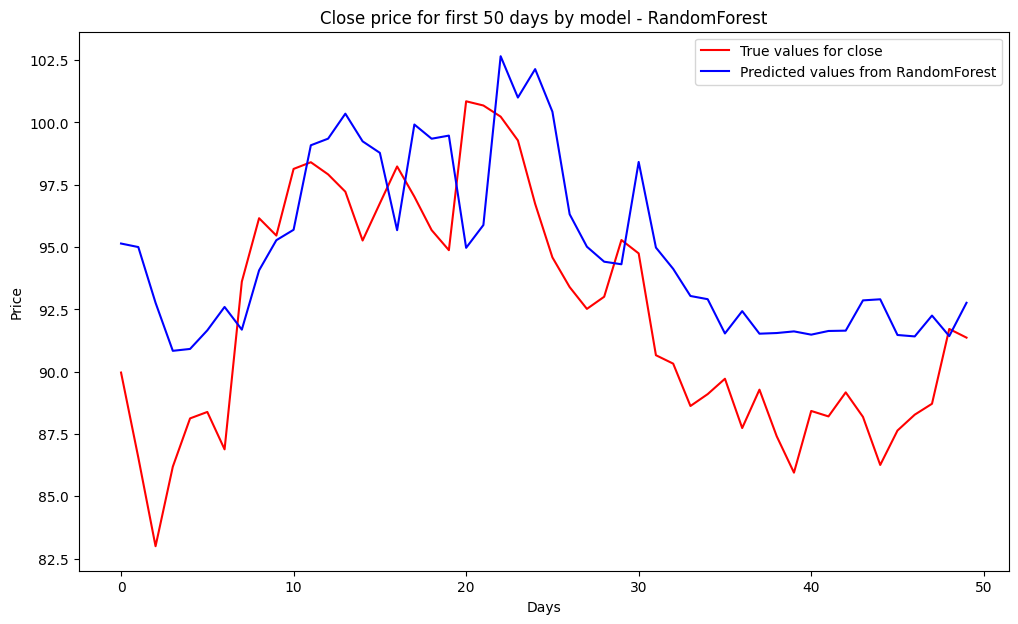

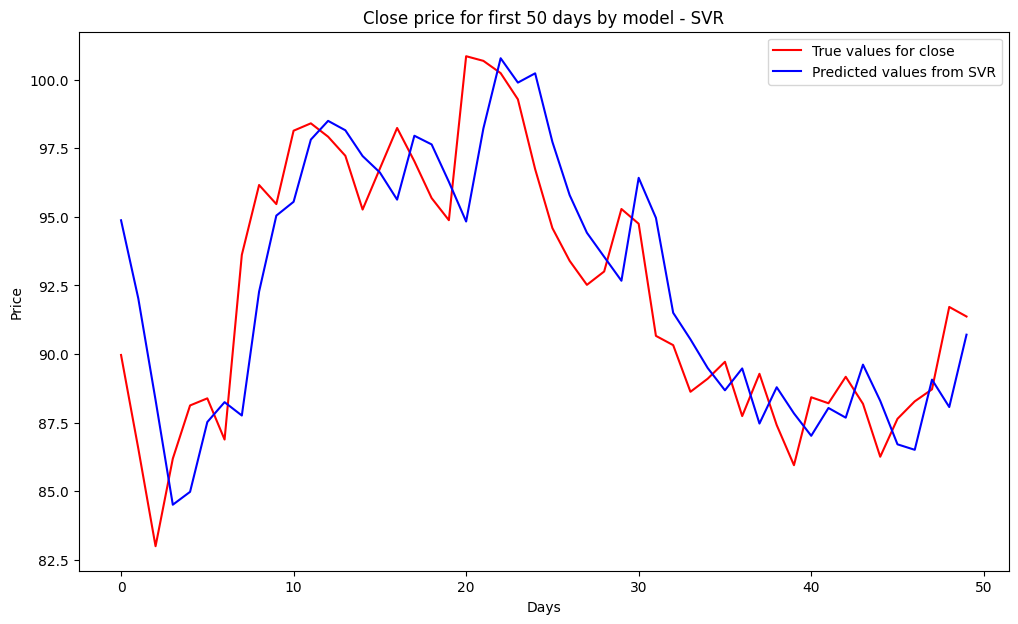

In [42]:
data = original_data.copy()

# we add technial indicators to the dataset 
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta<0, 0)).rolling(window=window).mean()
    rs = gain/loss.replace(0, np.nan)
    rsi = 100 - (100/(1+rs))
    return rsi

def compute_macd(data, short_period = 12, long_period= 26, signal_period = 9):
    data["EMA_short"] = data['Close'].ewm(span=short_period, adjust=False).mean()
    data["EMA_long"] = data['Close'].ewm(span=long_period, adjust=False).mean()

    data['MACD'] = data['EMA_short'] - data['EMA_long']
    data['Signal_Line'] = data['MACD'].ewm(span=signal_period, adjust=False).mean()
    return data
                                         
#relative strength index (RSI) - a indicator for momentum
data['RSI'] = compute_rsi(data)

#simple moving average(SMA) - a indictaor for trend
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

#MACD - a trend-following momentum indicator
data = compute_macd(data)

data['Next_Close'] = data['Close'].shift(-1)  # target variable

# drop rows with NaN values
data.dropna(inplace=True)

# Features and target variable
X = data[['Open','High','Low','Volume', 'SMA_20', 'SMA_50','RSI', 'MACD', 'Signal_Line']]
y = data['Next_Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

#Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


models = {
    'RandomForest': {
        'model' : RandomForestRegressor(random_state=42),
        'params' : {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10, 20]
        }
    },
    'SVR': {
        'model' : SVR(),
        'params' : {
            'kernel': ['rbf', 'poly', 'linear'],
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }
    }
}

y_pred_dict = {}

for name, dict in models.items():

    #Define the models and their hyperparameters for GridSearch 
    model = dict['model']

    params = dict['params']

    # Grid Search (cv - cross validation, n_jobs - no of jobs to run in parallel, verbose - information)
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error',n_jobs=-1,verbose=1)

    print("Starting the grid search to finding optimal hyperparameters")
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("\nGrid Search completed.")
    print("Best Parameters found:", best_params)
    print(f"Best cross-validated MSE during search: {best_score:.4f}")

    # optimal_model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], random_state=42)

    optimal_model = grid_search.best_estimator_
    optimal_model.fit(X_train, y_train)

    y_pred = optimal_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    print(f"{name} mse : {mse}")

    y_pred_dict[name] = y_pred

for name, y_pred in y_pred_dict.items():
    #visualize 
    plt.figure(figsize=(12, 7))
    plt.plot(y_test.values[:50], label="True values for close", color='red')
    plt.plot(y_pred[:50], label=f"Predicted values from {name}", color='blue')
    plt.title(f"Close price for first 50 days by model - {name}")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.show()